# Нечеткие автоматы

In [1]:
import numpy as np
import torch

In [2]:
import sys
sys.path.insert(0, './python')

In [3]:
from fuzzy_torch import logic
from fuzzy_torch.modules import ffsa, indicators

In [4]:
import matplotlib
import matplotlib.pyplot as plt

font = {'family' : 'Liberation Sans',
        'weight' : 'normal',
        'size'   : 30}

matplotlib.rc('font', **font)

## Проверка переходов

In [5]:
Logic = logic.Hamacher
fuzzy_fsa = ffsa.TimeIndependentFFSA(Logic)

In [6]:
# Добавление состояний и переходов.
fuzzy_fsa.states = [0, 1]
fuzzy_fsa.transitions.append(ffsa.FuzzyTransition(0, 1, indicators.Sigmoid(1, 1.0, 0.0)))

In [7]:
# Начальные активации.
activation = torch.tensor(np.array([[1.0, 0.0],
                                    [1.0, 0.0],
                                    [1.0, 0.0],
                                    [1.0, 0.0]]).astype(np.float32), requires_grad=True)

# Последовательности.
sequence = torch.tensor(np.array([[-1.0, -1.0, 0.0, 1.0, 1.0],
                                  [-10.0, -5.0, -1.0, 0.0, 10.0],
                                  [-10.0, -10.0, -10.0, -10.0, 0.0],
                                  [-0.5, -0.5, -0.5, -0.5, -0.5]]).astype(np.float32), requires_grad=True)

In [8]:
Activations = [activation]
for step in range(sequence.size()[1]):
    Activations.append(fuzzy_fsa(sequence[:, step][:,None], Activations[-1]))

In [9]:
torch.sum(Activations[-1][:,1]).backward()

In [10]:
Activations

[tensor([[1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.]], requires_grad=True),
 tensor([[7.3106e-01, 2.6894e-01],
         [9.9995e-01, 4.5598e-05],
         [9.9995e-01, 4.5598e-05],
         [6.2246e-01, 3.7754e-01]], grad_fn=<DivBackward0>),
 tensor([[5.9105e-01, 4.0895e-01],
         [9.9326e-01, 6.7380e-03],
         [9.9991e-01, 9.1192e-05],
         [4.8782e-01, 5.1218e-01]], grad_fn=<DivBackward0>),
 tensor([[4.3803e-01, 5.6197e-01],
         [7.2794e-01, 2.7206e-01],
         [9.9986e-01, 1.3678e-04],
         [4.1314e-01, 5.8686e-01]], grad_fn=<DivBackward0>),
 tensor([[3.4618e-01, 6.5382e-01],
         [4.7581e-01, 5.2419e-01],
         [9.9982e-01, 1.8237e-04],
         [3.6412e-01, 6.3588e-01]], grad_fn=<DivBackward0>),
 tensor([[0.3001, 0.6999],
         [0.3323, 0.6677],
         [0.5000, 0.5000],
         [0.3289, 0.6711]], grad_fn=<DivBackward0>)]

In [11]:
sequence.grad

tensor([[9.8177e-03, 8.5101e-03, 1.6009e-02, 9.7718e-03, 6.5077e-03],
        [3.5921e-07, 5.3313e-05, 3.3470e-03, 1.0306e-02, 4.1320e-06],
        [4.1412e-09, 4.1392e-09, 4.1372e-09, 4.1365e-09, 2.4991e-01],
        [3.7110e-02, 2.4687e-02, 1.9985e-02, 1.7286e-02, 1.5469e-02]])

In [12]:
print(fuzzy_fsa.transitions[0].condition.linear.weight.grad)
print(fuzzy_fsa.transitions[0].condition.linear.bias.grad)

tensor([[-0.0629]])
tensor([0.4288])


## Последовательность с переключением

In [13]:
class SwitchingRegressor(torch.nn.Module):
    def __init__(self, logic, ffsa):
        super().__init__()
        self.logic = logic
        self.ffsa = ffsa
        self.debug = False
        
    def forward(self, input, init_activation):
        steps = input.size()[1]
        
        activations = [init_activation]
        outputs = []
        for step in range(steps):
            # Срез входа по текущему шагу.
            input_on_current_step = input[:, step]
            
            # Новые активации (согласно нечеткому конечному автомату).
            activations.append(self.ffsa(input_on_current_step, activations[-1]))
            
            # Получение выходов регрессоров.
            output = [state(input_on_current_step) for state in self.ffsa.states]
            output = torch.stack(output, dim=1)
            outputs.append(torch.einsum("bo,bo...->b...", activations[-1], output))
            
        return torch.stack(outputs, dim=1), torch.stack(activations, dim=1)

In [14]:
# Логика.
#Logic = logic.Godel
#Logic = logic.Product
#Logic = logic.Lukasiewicz
#Logic = logic.Nilpotent
Logic = logic.Hamacher

In [15]:
regressor = SwitchingRegressor(Logic, ffsa.TimeIndependentFFSA(Logic, normalize=True))

In [16]:
regressor.ffsa.states = torch.nn.ModuleList([torch.nn.Linear(2, 1), torch.nn.Linear(2, 1), torch.nn.Linear(2, 1)])
regressor.ffsa.transitions = torch.nn.ModuleList([ffsa.FuzzyTransition(0, 1, indicators.Sigmoid(2)),
                                                  ffsa.FuzzyTransition(0, 2, indicators.Sigmoid(2))])

### Набор данных

In [17]:
import scipy.stats as stats

class SwitchingSequences(torch.utils.data.Dataset):
    def __init__(self, length=100, delta=3):       
        self.length = length
        self.delta = delta
        self.noize = stats.norm()
    
    def __len__(self):
        return 16384
    
    def __getitem__(self, idx):
        switch_index_start = np.random.choice(np.arange(0, self.length - self.delta - 1), 1)[0]
        switch_index_end = np.random.choice(np.arange(switch_index_start + self.delta, self.length), 1)[0]
        switch_type = np.random.choice([-1.0, 1.0], 1)[0]
        
        X = np.ones((self.length, 2))
        X[:,1] *= switch_type
        X[:switch_index_start, 1] = 0.0
        X[switch_index_end:, 1] = 0.0
        X += self.noize.rvs(X.shape) * 0.1
        
        y = np.ones((self.length))
        y[switch_index_start:] = 2.0 * switch_type * X[switch_index_start:, 0]
        y += self.noize.rvs(y.shape) * 0.1
        
        return X.astype(np.float32), y.astype(np.float32)[:, None]

In [18]:
dataset = SwitchingSequences()

In [19]:
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=512,
    shuffle=False,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )

In [20]:
import torch.optim as optim

optimizer = optim.Adam(regressor.parameters(), lr=0.1)

In [21]:
loss = torch.nn.MSELoss()

for epoch in range(20):
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        x, true_y = data
        init_activations = torch.zeros(x.size()[0], 3)
        init_activations[:,0] = 1.0

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        y, activations = regressor(x, init_activations)
        eval_loss = loss(y, true_y)
        eval_loss.backward()
        optimizer.step()

        # print statistics
        running_loss += eval_loss.item()
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss:.3f}')
        running_loss = 0.0

print('Finished Training')

[1,     1] loss: 2.814
[1,     2] loss: 2.444
[1,     3] loss: 2.117
[1,     4] loss: 1.935
[1,     5] loss: 1.765
[1,     6] loss: 1.777
[1,     7] loss: 1.823
[1,     8] loss: 1.809
[1,     9] loss: 1.624
[1,    10] loss: 1.661
[1,    11] loss: 1.501
[1,    12] loss: 1.439
[1,    13] loss: 1.457
[1,    14] loss: 1.267
[1,    15] loss: 1.314
[1,    16] loss: 1.247
[1,    17] loss: 1.419
[1,    18] loss: 1.352
[1,    19] loss: 1.337
[1,    20] loss: 1.284
[1,    21] loss: 1.282
[1,    22] loss: 1.331
[1,    23] loss: 1.277
[1,    24] loss: 1.298
[1,    25] loss: 1.253
[1,    26] loss: 1.175
[1,    27] loss: 1.248
[1,    28] loss: 1.194
[1,    29] loss: 1.216
[1,    30] loss: 1.196
[1,    31] loss: 1.178
[1,    32] loss: 1.210
[2,     1] loss: 1.101
[2,     2] loss: 1.122
[2,     3] loss: 1.054
[2,     4] loss: 1.029
[2,     5] loss: 1.037
[2,     6] loss: 0.952
[2,     7] loss: 0.980
[2,     8] loss: 0.928
[2,     9] loss: 0.866
[2,    10] loss: 0.818
[2,    11] loss: 0.816
[2,    12] 

[12,     3] loss: 0.118
[12,     4] loss: 0.121
[12,     5] loss: 0.107
[12,     6] loss: 0.124
[12,     7] loss: 0.124
[12,     8] loss: 0.117
[12,     9] loss: 0.121
[12,    10] loss: 0.114
[12,    11] loss: 0.117
[12,    12] loss: 0.118
[12,    13] loss: 0.110
[12,    14] loss: 0.114
[12,    15] loss: 0.122
[12,    16] loss: 0.118
[12,    17] loss: 0.114
[12,    18] loss: 0.118
[12,    19] loss: 0.117
[12,    20] loss: 0.114
[12,    21] loss: 0.119
[12,    22] loss: 0.122
[12,    23] loss: 0.115
[12,    24] loss: 0.119
[12,    25] loss: 0.115
[12,    26] loss: 0.115
[12,    27] loss: 0.122
[12,    28] loss: 0.120
[12,    29] loss: 0.112
[12,    30] loss: 0.121
[12,    31] loss: 0.107
[12,    32] loss: 0.127
[13,     1] loss: 0.118
[13,     2] loss: 0.118
[13,     3] loss: 0.112
[13,     4] loss: 0.117
[13,     5] loss: 0.126
[13,     6] loss: 0.107
[13,     7] loss: 0.110
[13,     8] loss: 0.121
[13,     9] loss: 0.110
[13,    10] loss: 0.123
[13,    11] loss: 0.115
[13,    12] loss

In [28]:
X, y_true = dataset[0]
X = torch.tensor(X)[None,:]
y, activations = regressor(X, torch.tensor(np.array([[1.0, 0.0, 0.0]]).astype(np.float32)))

print(y_true.squeeze())
print(y.squeeze().detach().numpy())

[1.1868099  1.0159198  0.9539018  0.7925015  0.8921457  1.1885276
 0.90910196 0.9316398  1.027852   0.84252894 0.9892847  0.8456346
 0.89113885 1.1271486  1.1980494  1.0487659  0.9341449  1.1656114
 1.0519269  1.0963259  1.0161797  0.98742616 0.86568326 1.7582191
 2.0030184  1.9607613  2.314026   1.7967042  1.5962299  2.0154817
 1.9542606  1.8356978  1.7792705  2.0413504  2.1304073  1.970899
 1.8108772  1.9951969  1.9388725  1.7725916  2.1196282  2.1001358
 1.8947296  1.9761413  2.0706084  1.6759326  1.9312819  1.9618134
 1.6012131  1.9384878  2.045928   1.4118855  2.5346684  2.1245773
 2.2276337  2.0738668  1.841555   2.181368   2.0566614  2.082369
 1.9378566  1.9166218  2.0034757  2.3640435  2.0018957  2.3488905
 1.9168708  1.9356205  1.7917175  2.0676527  2.113404   1.8719455
 2.23317    2.0119815  1.8537215  1.8297791  1.6866583  2.0714686
 2.532174   1.9274054  1.7959852  1.8196914  1.7287942  2.1134791
 1.9266142  2.0474656  2.040435   2.1326513  1.7552822  1.9016744
 2.2443576  

In [29]:
activations.argmax(dim=2)

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])

In [30]:
activations.sum(dim=2)

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000]], grad_fn=<SumBackward1>)

In [31]:
print("Первое условие (параметры):")
print(regressor.ffsa.transitions[0].condition.linear.weight.detach().numpy())
print(regressor.ffsa.transitions[0].condition.linear.bias.detach().numpy())

print("Второе условие (параметры):")
print(regressor.ffsa.transitions[1].condition.linear.weight.detach().numpy())
print(regressor.ffsa.transitions[1].condition.linear.bias.detach().numpy())

Первое условие (параметры):
[[-2.9769783 -7.8515973]]
[-2.8698971]
Второе условие (параметры):
[[ -3.909462 -12.659309]]
[-5.5196843]


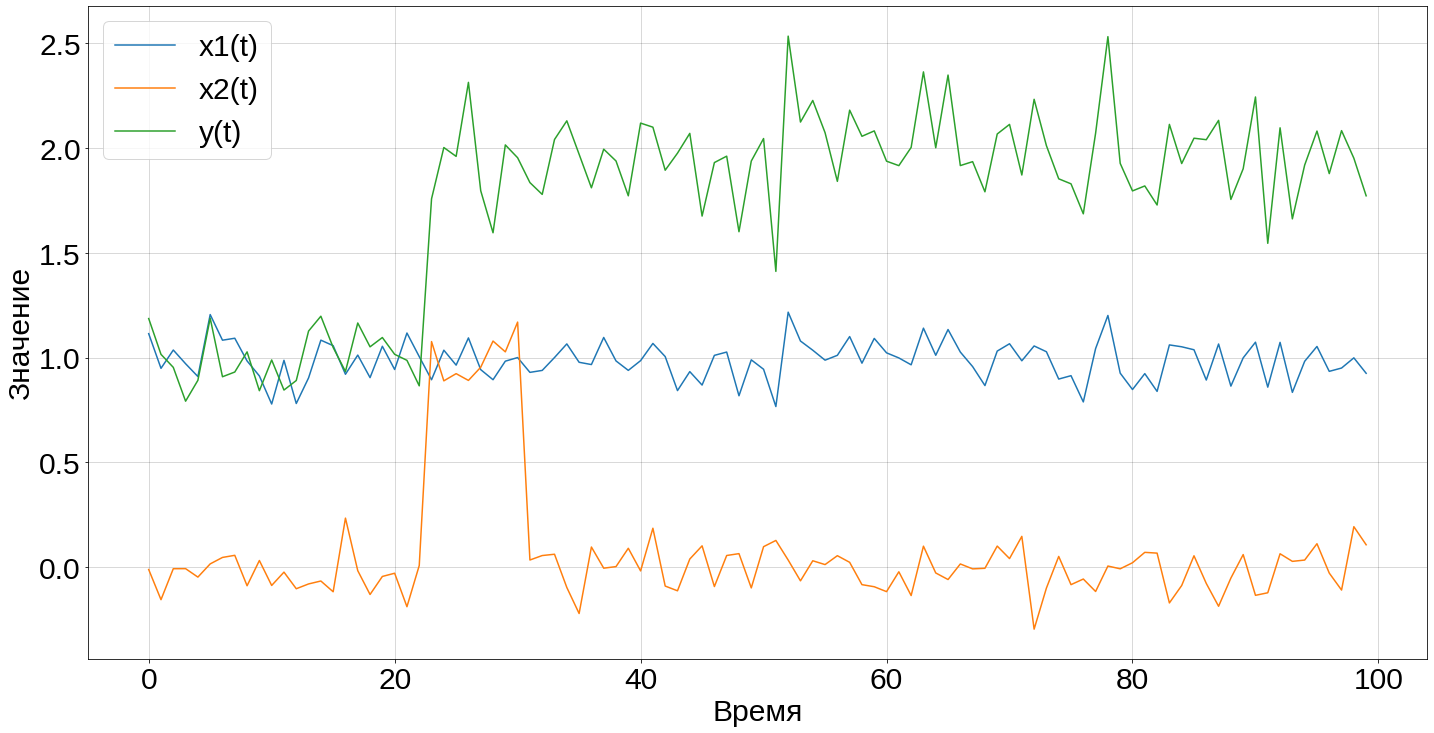

In [32]:
fig = plt.figure()
ax = fig.gca()

fig.set_figheight(12)
fig.set_figwidth(24)
ax.grid(color='#000000', alpha=0.15, linestyle='-', linewidth=1, which='major')
ax.grid(color='#000000', alpha=0.1, linestyle='-', linewidth=0.5, which='minor')

ax.set_xlabel('Время')
ax.set_ylabel('Значение')

T = np.arange(dataset.length)
ax.plot(T, X[0,:,0], label="x1(t)")
ax.plot(T, X[0,:,1], label="x2(t)")
ax.plot(T, y_true, label="y(t)")
#ax.plot(T, y[0].detach().numpy(), label="y'(t)")

ax.legend(loc='upper left')